# Babi Q&A Chatbot Project

## Overview:

### This project is based on the Babi dataset from Facebook Research
The bAbI dataset, created by Facebook, is a collection of tasks designed for testing text understanding and reasoning in natural language processing. It includes 20 unique tasks, each testing a different aspect of text and reasoning. For each task, there are 1000 questions for training and 1000 for testing. The goal is to use as little data as possible to do well on the tasks without resorting to task-specific tricks.

## Useful Links:
#### https://www.kaggle.com/datasets/roblexnana/the-babi-tasks-for-nlp-qa-system
#### http://arxiv.org/abs/1502.05698
#### http://www.thespermwhale.com/jaseweston/babi/abordes-ICLR.pdf
#### https://arxiv.org/abs/1503.08895

## Loading the data

In [1]:
import pickle
import numpy as np

In [2]:
# Using the 'with' statement to open a file ensures that it's properly closed after its associated block of code is executed.
with open("train_qa.txt", "rb") as fp:   # Unpickling
    train_data =  pickle.load(fp)

In [3]:
with open("test_qa.txt", "rb") as fp:   # Unpickling
    test_data =  pickle.load(fp)

---

## Exploring the Format of the Data

In [4]:
type(test_data)

list

In [5]:
type(train_data)

list

In [6]:
len(test_data)

1000

In [7]:
len(train_data)

10000

In [8]:
# Each item in the train/test dataset is organized as a tuple of story, question, and answer.
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [9]:
# Story
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [10]:
# Question
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [11]:
# Answer
train_data[0][2]

'no'

-----

## Setting up Vocabulary of All Words

In [12]:
# Creating a set that holds the vocabulary words
vocab = set()

In [13]:
all_data = test_data + train_data

In [14]:
# Iterate over each entry in the all_data list.
for story, question , answer in all_data:
    # Update the vocab set with unique words from the story.
    vocab = vocab.union(set(story))
    # Update the vocab set with unique words from the question.
    vocab = vocab.union(set(question))

In [15]:
# Add the word 'no' to the vocab set.
vocab.add('no')
# Add the word 'yes' to the vocab set.
vocab.add('yes')

In [16]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [17]:
# Calculate the length of the vocab set and add 1.
# The additional 1 is to account for a padding token (0) used by Keras's pad_sequences function.
vocab_len = len(vocab) + 1 

In [18]:
max_story_len = max([len(data[0]) for data in all_data])

In [19]:
# Will need this information later on when padding sequences
max_story_len

156

In [20]:
max_question_len = max([len(data[1]) for data in all_data])

In [21]:
# Will need this information  later on when padding sequences
max_question_len

6

## Vectorizing the Data

In [22]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [23]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [24]:
from keras.preprocessing.sequence import pad_sequences
# (needed when running this project in Amazon Sagemaker Studio Labs or an error occurs):
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [25]:
# Initialize a Keras Tokenizer object.
# The 'filters' argument is set to an empty list, which means no characters will be filtered out during tokenization.
tokenizer = Tokenizer(filters=[])

# Fit the tokenizer on the vocab set.
# This step prepares the tokenizer to convert words in the vocab to their corresponding integer values.
tokenizer.fit_on_texts(vocab)

In [26]:
# Access the dictionary of word-to-integer mappings created by the tokenizer.
tokenizer.word_index

{'?': 1,
 'back': 2,
 'grabbed': 3,
 'discarded': 4,
 'mary': 5,
 '.': 6,
 'office': 7,
 'picked': 8,
 'put': 9,
 'journeyed': 10,
 'to': 11,
 'left': 12,
 'apple': 13,
 'went': 14,
 'football': 15,
 'took': 16,
 'bedroom': 17,
 'no': 18,
 'kitchen': 19,
 'there': 20,
 'got': 21,
 'is': 22,
 'john': 23,
 'travelled': 24,
 'sandra': 25,
 'bathroom': 26,
 'dropped': 27,
 'daniel': 28,
 'moved': 29,
 'hallway': 30,
 'in': 31,
 'garden': 32,
 'down': 33,
 'the': 34,
 'yes': 35,
 'up': 36,
 'milk': 37}

### Functionalize Vectorization

In [27]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [28]:
# Call the vectorize_stories function on the train_data to get vectorized versions of stories, questions, and answers.
# inputs_train will contain the vectorized stories, queries_train will contain the vectorized questions, 
# and answers_train will contain the one-hot encoded answers.
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [29]:
# Same as previous, but for test dataset.
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [30]:
inputs_test

array([[ 0,  0,  0, ..., 34, 17,  6],
       [ 0,  0,  0, ..., 34, 32,  6],
       [ 0,  0,  0, ..., 34, 32,  6],
       ...,
       [ 0,  0,  0, ..., 34, 13,  6],
       [ 0,  0,  0, ..., 34, 32,  6],
       [ 0,  0,  0, ..., 13, 20,  6]])

In [31]:
queries_test

array([[22, 23, 31, 34, 19,  1],
       [22, 23, 31, 34, 19,  1],
       [22, 23, 31, 34, 32,  1],
       ...,
       [22,  5, 31, 34, 17,  1],
       [22, 25, 31, 34, 32,  1],
       [22,  5, 31, 34, 32,  1]])

In [32]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [33]:
# Compute the sum of the one-hot encoded answers in answers_test.
# This can provide the total count of each answer type in the test dataset.
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 497.,   0.,   0.])

In [34]:
# Retrieve the integer value assigned to the word 'yes' from the tokenizer's word_index dictionary.
tokenizer.word_index['yes']

35

In [35]:
# Retrieve the integer value assigned to the word 'no' from the tokenizer's word_index dictionary.
tokenizer.word_index['no']

18

## Creating the Model

In [36]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [37]:
'''
Placeholders for Inputs:
Recall we technically have two inputs, stories and questions. So we need to use placeholders.
''' 
# Define the input layer for the story sequences. 
# The shape argument defines the dimensions of the input data. 'max_story_len' specifies the maximum length of a story.
# This layer will expect input data with a shape of (batch_size, max_story_len).
input_sequence = Input((max_story_len,))

# Define the input layer for the question sequences.
# Similarly, 'max_question_len' specifies the maximum length of a question.
# This layer will expect input data with a shape of (batch_size, max_question_len).
question = Input((max_question_len,))

## Encoders

### Input Encoder m

In [38]:
# Initialize a sequential model for encoding the input sequences (stories).
input_encoder_m = Sequential()

# Add an embedding layer to the encoder.
# This layer will transform integer-encoded words into vectors of fixed size (64 in this case).
# 'vocab_size' is the number of unique words (tokens) in the vocabulary.
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))

# Add a dropout layer to the encoder.
# Dropout is a regularization technique where randomly selected neurons are ignored (or "dropped-out") during training.
# This helps in preventing overfitting.
input_encoder_m.add(Dropout(0.3)) 

# The output shape of this encoder will be:
# (samples, story_maxlen, embedding_dim)
# Where 'samples' is the number of stories in the batch, 'story_maxlen' is the maximum length of any story, 
# and 'embedding_dim' is the dimension of the embedded word vectors (64 in this case).

### Input Encoder c

In [39]:
# Initialize another sequential model for encoding the input sequences.
input_encoder_c = Sequential()

# Add an embedding layer to this encoder.
# Unlike the previous encoder, the output dimension here is set to 'max_question_len'.
# This means each word in the story will be embedded into a vector of size 'max_question_len'.
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))

# Add a dropout layer for regularization.
# As before, this layer randomly turns off a percentage of neurons during training to help with overfitting.
input_encoder_c.add(Dropout(0.3))


# The output shape of this encoder will be:
# (samples, story_maxlen, query_maxlen)
# Where 'samples' is the number of stories in the batch, 'story_maxlen' is the maximum length of any story, 
# and 'query_maxlen' is the maximum length of any question.

### Question Encoder

In [40]:
# Initialize a sequential model for encoding the questions.
question_encoder = Sequential()

# Add an embedding layer to the encoder.
# This layer will transform integer-encoded words in the question into vectors of fixed size (64 in this case).
# The 'input_length' argument specifies that the input to this layer will always have a fixed length of 'max_question_len'.
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))

question_encoder.add(Dropout(0.3))

# The output shape of this encoder will be:
# (samples, query_maxlen, embedding_dim)
# Where 'samples' is the number of questions in the batch, 'query_maxlen' is the maximum length of any question, 
# and 'embedding_dim' is the dimension of the embedded word vectors (64 in this case).

### Encode the Sequences

In [41]:
# Transform the input story sequences into dense vector representations using the 'input_encoder_m' model.
# This will result in a sequence of vectors for each story.
input_encoded_m = input_encoder_m(input_sequence)

# Transform the same input story sequences using the 'input_encoder_c' model.
# This will produce a different representation compared to 'input_encoded_m'.
input_encoded_c = input_encoder_c(input_sequence)

# Transform the question sequences into dense vector representations using the 'question_encoder' model.
# This will result in a sequence of vectors for each question.
question_encoded = question_encoder(question)

### Use dot product to compute the match between first input vector seq and the query

In [42]:
# Compute the dot product between the embedded stories (`input_encoded_m`) and embedded questions (`question_encoded`).
# This will effectively measure the similarity between each word in the story and the entire question.
# The resulting shape will be `(samples, story_maxlen, query_maxlen)`, representing similarity scores.
match = dot([input_encoded_m, question_encoded], axes=(2, 2))

# Apply a softmax activation to the similarity scores.
# This will turn the scores into "attention weights", where higher values mean a particular word in the story 
# is more relevant to the question. The softmax ensures that the weights sum to 1 for each story word.
match = Activation('softmax')(match)

### Add this match matrix with the second input vector sequence

In [43]:
# Combine (add) the attention weights (match) with the encoded representations of the stories (`input_encoded_c`).
# This operation essentially weighs the story representations based on their relevance to the question.
# The resulting tensor has shape `(samples, story_maxlen, query_maxlen)`.
response = add([match, input_encoded_c])

# Permute the dimensions of the `response` tensor.
# This swaps the 'story_maxlen' and 'query_maxlen' dimensions, resulting in a shape of `(samples, query_maxlen, story_maxlen)`.
response = Permute((2, 1))(response)

### Concatenate

In [44]:
# Concatenate the weighted story representations (`response`) with the encoded questions (`question_encoded`).
# This combined representation provides a richer context that captures both the relevant parts of the story 
# and the specifics of the question.
answer = concatenate([response, question_encoded])

In [45]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [46]:
# Process the combined story and question representation using an LSTM layer.
# The LSTM layer will analyze the sequence and produce a fixed-size output vector (with 32 dimensions in this case).
# This output captures the most important features of the input sequence for the task at hand.
answer = LSTM(32)(answer)

In [47]:
# Apply dropout regularization to the LSTM outputs.
# Dropout randomly sets a fraction (0.5 or 50% in this case) of input units to 0 at each update during training, 
# which helps to prevent overfitting.
answer = Dropout(0.5)(answer)

# Add a Dense layer to transform the outputs from the Dropout layer.
# This layer will have as many neurons as there are words in the vocabulary.
# It will produce an output vector of shape `(samples, vocab_size)`, where each entry in the vector can be thought of 
# as the model's confidence that a particular word in the vocabulary is the correct answer.
answer = Dense(vocab_size)(answer)  

In [48]:
# Apply a softmax activation to the `answer` tensor.
# This will convert the dense layer's outputs into a probability distribution over the vocabulary.
# Each entry in the output will represent the model's confidence that a particular word in the vocabulary is the correct answer.
answer = Activation('softmax')(answer)

# Build the final Keras model.
# The model takes two inputs: the story (`input_sequence`) and the question.
# It outputs the probability distribution over the vocabulary (the `answer` tensor).
model = Model([input_sequence, question], answer)

# Compile the model to configure the training process.
# - The optimizer is set to 'rmsprop', which is a commonly used optimizer for RNNs.
# - The loss function is 'categorical_crossentropy', suitable for multi-class classification problems.
# - The model will also compute accuracy as a metric during training and evaluation.
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 64)             2432      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 6, 64)                2432      ['input_2[0][0]']             
                                                                                              

In [50]:
# Train the model on the training data.
# - The training data consists of stories (`inputs_train`) and questions (`queries_train`).
# - The target labels are the correct answers (`answers_train`).
# - The model is trained using mini-batch gradient descent with a batch size of 32.
# - The training process will run for 120 epochs.
# - At the end of each epoch, the model's performance is evaluated on the test data (`inputs_test`, `queries_test`, and `answers_test`).
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=100,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 8s 15ms/step - loss: 0.9069 - accuracy: 0.4911 - val_loss: 0.6962 - val_accuracy: 0.4970
Epoch 2/100
313/313 [==============================] - 4s 13ms/step - loss: 0.7069 - accuracy: 0.4971 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 3/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6974 - accuracy: 0.5015 - val_loss: 0.6933 - val_accuracy: 0.5030
Epoch 4/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6971 - accuracy: 0.4983 - val_loss: 0.6959 - val_accuracy: 0.4970
Epoch 5/100
313/313 [==============================] - 5s 14ms/step - loss: 0.6955 - accuracy: 0.5009 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6951 - accuracy: 0.5042 - val_loss: 0.6956 - val_accuracy: 0.4970
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6961 - accuracy: 0.4907 - val_loss: 0.6948 - val_accuracy:

### Saving the Model

In [51]:
filename = 'Babi_q_and_a.keras'
model.save(filename)

## Evaluating the Model

### Plotting Out Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


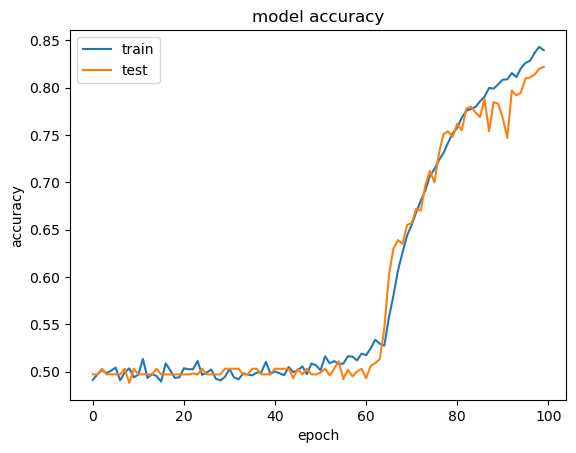

In [52]:
import matplotlib.pyplot as plt

# Print the keys available in the history object.
# This gives an idea of the metrics that were recorded during training.
print(history.history.keys())

# Plot the training accuracy recorded at each epoch.
plt.plot(history.history['accuracy'])

# Plot the validation accuracy recorded at each epoch.
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating on Given Test Set

In [53]:
model.load_weights('Babi_q_and_a.keras')

# Use the model to make predictions on the test dataset.
# The predictions will be in the form of probability distributions over the vocabulary for each test sample.
pred_results = model.predict(([inputs_test, queries_test]))

32/32 [==============================] - 1s 4ms/step


In [54]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [55]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [56]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [57]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [58]:
# Find the index of the maximum value in the first prediction result.
# This corresponds to the word (answer) that the model is most confident about for the first test sample.
val_max = np.argmax(pred_results[0])

# Iterate over the items in the tokenizer's word_index dictionary.
# This dictionary maps words to their corresponding integer values.
# The goal is to find the word associated with the maximum value in the prediction.
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key   # Store the word that corresponds to the maximum value.

# Print the predicted answer.
print("Predicted answer is: ", k)

# Print the model's confidence (probability) associated with this answer.
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9749196


## Writing Your Own Stories and Questions

Remember you can only use words from the existing vocab

In [59]:
# Running this cell displays the list of vocabulary words we can use
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [60]:
# Define a string `my_story` containing a short narrative.
# Note that there are whitespaces before the periods, which will affect the splitting.
my_story = "John left the kitchen . Sandra dropped the football in the garden ."

# Use the `split()` method to divide the `my_story` string into individual words and punctuation marks.
# Since no delimiter is specified, `split()` will use whitespace as the default delimiter.
# As a result, the periods will be separate items in the resulting list due to the preceding whitespace.
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [61]:
my_question = "Is the football in the garden ?"
my_question.split() 

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [62]:
# Create a new list `mydata` to store the story, question, and answer data.

# `my_story.split()` takes the `my_story` string and splits it into individual words and punctuation.
# Each word or punctuation mark becomes a separate element in a list.

# `my_question.split()` does the same for the `my_question` string.

# 'yes' is the answer associated with this particular story and question.
mydata = [(my_story.split(),my_question.split(),'yes')]

In [63]:
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [64]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [65]:
my_story

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 23,
        12, 34, 19,  6, 25, 27, 34, 15, 31, 34, 32,  6]])

In [66]:
pred_results = model.predict(([ my_story, my_ques]))

1/1 [==============================] - 0s 16ms/step


In [67]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.97491986
